In [2]:
# Improts and setup
import pandas as pd
import seaborn as sb
import statsmodels
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sb.set_style('darkgrid')
sb.set_context('talk')
sb.set_palette('muted')

In [4]:
# Load data and conver to datatime objects 
pro_data = pd.read_csv('cca_data_pro.csv')
pro_data.MOT = pd.to_datetime(pro_data.MOT)
pro_data.year = pd.to_datetime(pro_data.year)

# Summary of EDA so far.

From previous [exploritory data analysis](Car_Auction_EDA.ipynb) we can see that the price a car is auctioned for is:

* Positively correlated with year of manufacture [R = 0.6]. i.e the newer the car the more it fetches. 
* Slightly negatively correlated with the amount of mileage the car has done [R = -0.3]. 

From the first run at using [Gradient Boosted Decision Trees](Car_Auction_Preliminary_Analysis_GBRT.ipynb), the most frequently used features in predicting the cars final hammer price are, in acending order: "make" > "mileage" > "year of manufacture".

In additon, the populatity and spread of prices for each model is show in a summary figure below:


          Distribution of Hammer Price per Model of Car


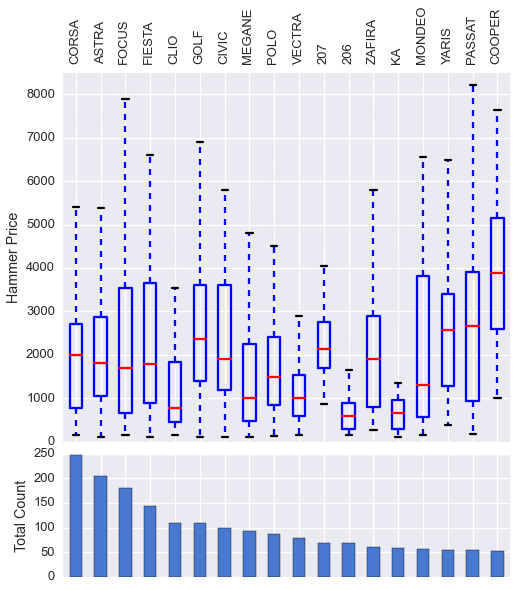

In [16]:
# Visualise as a boxplot
from matplotlib.gridspec import GridSpec
fig = plt.figure( figsize=(8,8))

gs1 = GridSpec(2, 1, height_ratios=[3,1])
gs1.update(top = 1.00, hspace=0.05)
ax1 = plt.subplot(gs1[1, :])
ax2 = plt.subplot(gs1[0, :])

# Set filter threshold, those less than this will not be plotted
threshold = 50 

make_freqs = pro_data['model'].value_counts()
make_freqs[make_freqs > threshold].plot(kind='bar', ax = ax1)
ax1.set_xticklabels('')
ax1.set_ylabel('Total Count')
ax1.set_xlabel('Model')
           
columns_my_order = list(make_freqs[make_freqs > threshold].index)
grouped = pro_data.groupby('model')

ax = ax2
for position, column in enumerate(columns_my_order):
    data = grouped.price.get_group(column).values
    ax.boxplot(data, positions=[position], widths=0.5)

ax.set_xticks(range(position+1))
ax.set_xticklabels(columns_my_order, rotation=90)
ax.set_xlim(xmin=-0.5)
ax.set_ylabel('Hammer Price')
ax.set_ylim(ymax=8500)

for tick in ax.xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')

print('\n          Distribution of Hammer Price per Model of Car')
plt.show()

## So Which Model of Car Holds its Value the Best Over Time? 

A complication to answering this question is that we do not have the date the car was auctioned on, though we do have a proxy for this, the MOT date, which if given would normaly be up to 1 year in advance of the auction date. Though new cars would not need an MOT untill after the first three years. 

For simplicity and as a rough approximation I will take one year from the MOT date as the auction date for the vehicle and calculate the "age at sale" in years as a floating point number.   

In [6]:
pro_data['approx_sale_date'] = pro_data.MOT - pd.Timedelta('365 days')
pro_data['age_at_sale'] = pd.to_timedelta(pro_data['approx_sale_date'] - pro_data.year)
pro_data['age_at_sale'] = pro_data['age_at_sale'].dt.days / 365

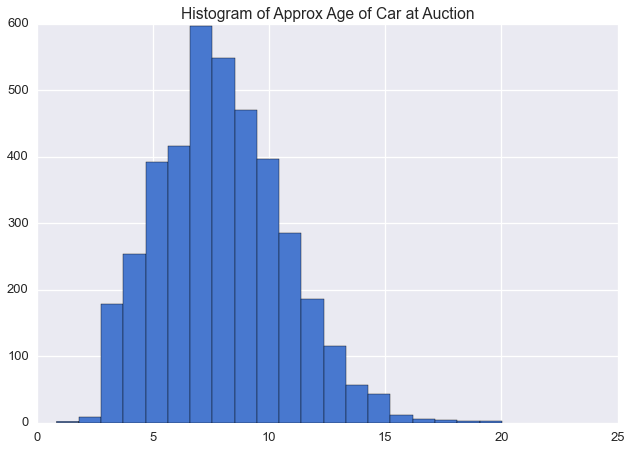

In [17]:
ax = pro_data['age_at_sale'].hist(bins = 20)
ax.set_title('Histogram of Approx Age of Car at Auction')

So we can see that the majority of cars are between 3 to 13 years only when sold. Therefore one way to answer Q1 is to look at the values a model fetches when grouped by years old 3 - 15 (rounded down).

In [8]:
pro_data['age_at_sale_rounded'] = np.floor(pro_data.age_at_sale)

In [9]:
# Create index to subset only models that occure more than 50 times and 
# have a date for MOT
models = (pro_data.model.value_counts() > 50).index
include_idx = pro_data.model.isin(models) 
MOT_idx = pro_data.MOT.notnull()
subset_idx = include_idx & MOT_idx

Now I construct a plot that displays the distribution of hammer price for the tow three models, 'CORSA', 'ASTRA', 'FOCUS' and 'FIESTA' over the age at sale varibale calculated.

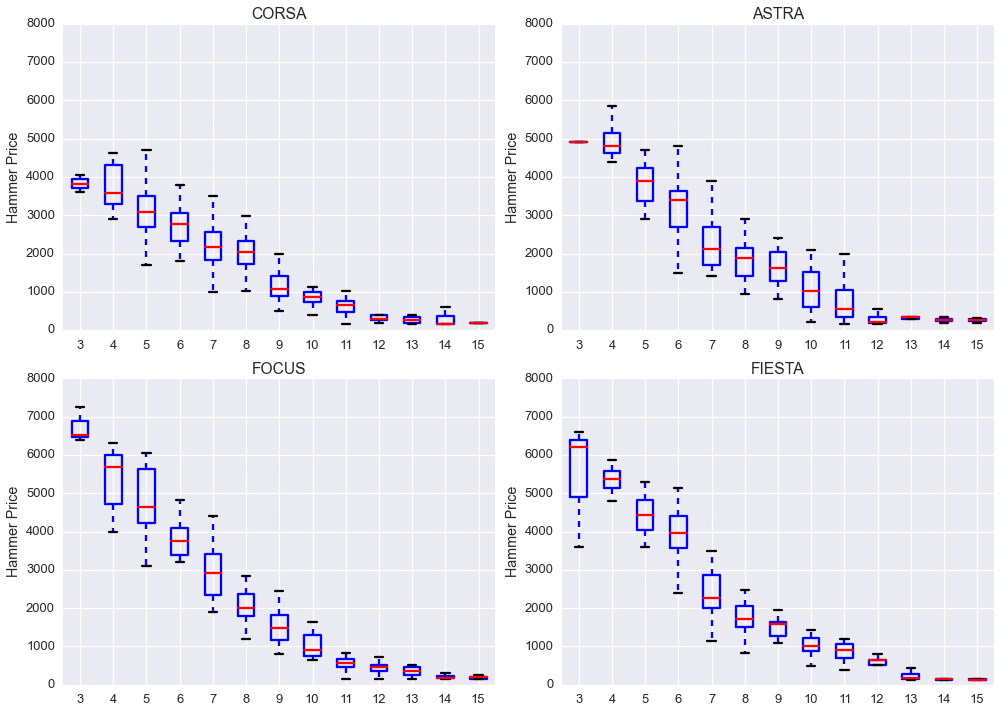

In [18]:
from collections import defaultdict

# Plot of Price distributions over age at sale
fig = plt.figure( figsize=(14,10))
models = ['CORSA', 'ASTRA', 'FOCUS', 'FIESTA']

medians = defaultdict(list)

for i, mod in enumerate(models):
    
    ax = plt.subplot(int('22' + str(i+1)))
    
    model_idx = pro_data.model == mod

    x_var = pd.unique(pro_data.ix[subset_idx & model_idx, 'age_at_sale_rounded'])
    x_var.sort()
    x_var = np.arange(2, 15)
    
    grouped = pro_data.ix[subset_idx & model_idx, :].groupby('age_at_sale_rounded')

    for position, column in enumerate(x_var):
        
        if len(grouped.price.get_group(column)) == 0:
            medians[mod].append(0)
        else:
            medians[mod].append(grouped.price.get_group(column).median())
        data = grouped.price.get_group(column).values
        ax.boxplot(data, positions=[position], widths=0.5)

    ax.set_xticks(range(position+1))
    ax.set_xticklabels((x_var+1).astype(int))
    ax.set_xlim(xmin=-0.5)
    ax.set_ylabel('Hammer Price')
    ax.set_ylim(ymax=8000)
    ax.set_title(mod)

plt.tight_layout()

There is a clear pattern of depreciation with all models, though as each has a different starting retail value, it is best to compare relative values. The below plot does this for the median prices, expressed as a percentage of the maximum median (median price after 3 years). 

In [19]:
df_medians = pd.DataFrame(medians)

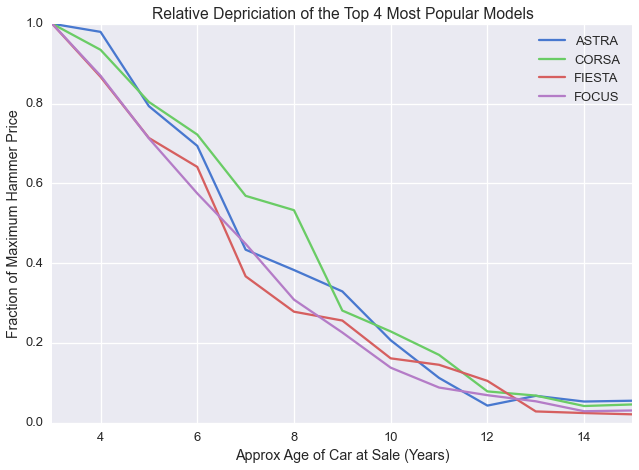

In [20]:
percentage_max_median = df_medians / df_medians.max()
ax = percentage_max_median.plot(x=(x_var+1).astype(int))
ax.set_xlabel('Approx Age of Car at Sale (Years)')
ax.set_ylabel('Fraction of Maximum Hammer Price')
ax.set_title('Relative Depriciation of the Top 4 Most Popular Models')

As can be seen there is not very much in it, with all following the same general trend, though the median price of a Vauxal Corsa depreciates much less between the 7th and 8th year than the other models. 

## Age at sale vs Milage

As a sanity check, I looked to see if my approximated sale date is correlated with milage. Fitting a linear model gives a significant coeffecient for the gradient of 4,222 miles per year, with an intercept of 43,500 miles. 

This does seem quite a high intercept, though I suspect this is due to "spikes" in cars that have seen high mileage during thier early life, and are actioned as soon as the waranty expiers, typically after 3 years. 

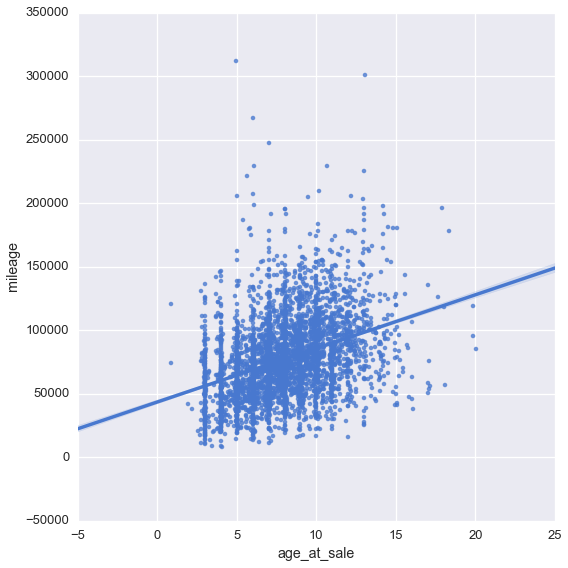

In [13]:
plt.figure(figsize=( 8, 12 ))
sb.lmplot("age_at_sale", "mileage", pro_data, ci=68, size=8)

In [14]:
import statsmodels.formula.api as smf
# Fit regression model
results = smf.ols('mileage ~ age_at_sale', data=pro_data).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                mileage   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     583.6
Date:                Tue, 07 Apr 2015   Prob (F-statistic):          2.12e-120
Time:                        01:50:12   Log-Likelihood:                -46580.
No. Observations:                3969   AIC:                         9.316e+04
Df Residuals:                    3967   BIC:                         9.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     4.35e+04   1467.030     29.653      